In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools

def expand_dont_care(pattern):
    """Expand a pattern like 'x10x0' to all possible combinations."""
    chars = [(c if c in '01' else ['0', '1']) for c in pattern]
    chars = [(c if isinstance(c, list) else [c]) for c in chars]
    return [''.join(bits) for bits in itertools.product(*chars)]

def parse_test_file(filepath):
    dataset = []
    current_fault = None

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("*"):
                continue

            if '/' in line:
                # It's a fault line: "n23 /0" or "n11->n19 /1"
                parts = line.split("/")
                fault = parts[0].strip().replace("->", "_") + "/" + parts[1].strip()
                current_fault = fault
            elif ':' in line:
                # It's a test vector line
                parts = line.split(":")[1].strip().split()
                input_pattern = parts[0]
                output_pattern = parts[1] if len(parts) > 1 else ""

                expanded_inputs = expand_dont_care(input_pattern)
                expanded_outputs = expand_dont_care(output_pattern)

                for xi in expanded_inputs:
                    for yo in expanded_outputs:
                        dataset.append({
                            "input": [int(bit) for bit in xi],
                            "output": [int(bit) for bit in yo],
                            "fault": current_fault
                        })

    return dataset

In [3]:
data = parse_test_file("/content/c17.flt")

for item in data[:20]:
    print(item)

{'input': [0, 0, 0, 0, 0], 'output': [0, 0], 'fault': 'n7/1'}
{'input': [0, 0, 0, 1, 0], 'output': [0, 0], 'fault': 'n7/1'}
{'input': [1, 0, 0, 0, 0], 'output': [0, 0], 'fault': 'n7/1'}
{'input': [1, 0, 0, 1, 0], 'output': [0, 0], 'fault': 'n7/1'}
{'input': [0, 0, 1, 1, 1], 'output': [0, 0], 'fault': 'n11_n19/1'}
{'input': [0, 0, 1, 1, 1], 'output': [1, 0], 'fault': 'n11_n19/1'}
{'input': [0, 1, 1, 1, 1], 'output': [0, 0], 'fault': 'n11_n19/1'}
{'input': [0, 1, 1, 1, 1], 'output': [1, 0], 'fault': 'n11_n19/1'}
{'input': [1, 0, 1, 1, 1], 'output': [0, 0], 'fault': 'n11_n19/1'}
{'input': [1, 0, 1, 1, 1], 'output': [1, 0], 'fault': 'n11_n19/1'}
{'input': [1, 1, 1, 1, 1], 'output': [0, 0], 'fault': 'n11_n19/1'}
{'input': [1, 1, 1, 1, 1], 'output': [1, 0], 'fault': 'n11_n19/1'}
{'input': [0, 1, 0, 0, 0], 'output': [1, 1], 'fault': 'n16_n23/1'}
{'input': [0, 1, 0, 1, 0], 'output': [1, 1], 'fault': 'n16_n23/1'}
{'input': [1, 1, 0, 0, 0], 'output': [1, 1], 'fault': 'n16_n23/1'}
{'input': [1, 1

In [13]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Separate inputs and labels
X = np.array([sample['input'] for sample in data])
y_labels = [sample['fault'] for sample in data]

# Encode fault labels as integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_labels)

# One-hot encode labels for classification
y = to_categorical(y_int)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

print(X_train.shape)

(240, 5)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train
model.fit(
    X_train, y_train,
    validation_split=0.5,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.0469 - loss: 3.1127 - val_accuracy: 0.0167 - val_loss: 3.0964 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0765 - loss: 3.0517 - val_accuracy: 0.0250 - val_loss: 3.0791 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1015 - loss: 3.0367 - val_accuracy: 0.0417 - val_loss: 3.0617 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0958 - loss: 2.9779 - val_accuracy: 0.0500 - val_loss: 3.0456 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1244 - loss: 2.9677 - val_accuracy: 0.0583 - val_loss: 3.0286 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1400 - loss: 2.9071 - val_accuracy: 0.0417 - val_loss: 3.0120 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1875 - loss: 2.8495 - val_accuracy: 0.0500 

In [24]:
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test accuracy: {acc:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1410 - loss: 2.6578
✅ Test accuracy: 13.33%


In [18]:
y_pred = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Print a few examples
for i in range(20):
    print(f"Predicted: {predicted_labels[i]} | Actual: {true_labels[i]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted: n16/0 | Actual: n3/1
Predicted: n22/0 | Actual: n10/1
Predicted: n23/1 | Actual: n16/0
Predicted: n16/0 | Actual: n11_n19/1
Predicted: n11/0 | Actual: n16_n22/1
Predicted: n16/0 | Actual: n3_n10/1
Predicted: n3/1 | Actual: n3/1
Predicted: n11/0 | Actual: n11/0
Predicted: n16/0 | Actual: n11_n19/1
Predicted: n16/1 | Actual: n16/1
Predicted: n16/1 | Actual: n16_n22/1
Predicted: n16/0 | Actual: n23/1
Predicted: n16/0 | Actual: n1/1
Predicted: n22/0 | Actual: n19/1
Predicted: n3_n11/1 | Actual: n16/1
Predicted: n3/1 | Actual: n3_n10/1
Predicted: n16/0 | Actual: n22/1
Predicted: n16/0 | Actual: n3/0
Predicted: n22/1 | Actual: n16/0
Predicted: n22/1 | Actual: n16/0


In [19]:
import numpy as np

# Get raw predictions
y_pred = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [20]:
from collections import defaultdict

# Group results by SA0 and SA1
fault_types = defaultdict(list)

for pred, actual in zip(predicted_labels, true_labels):
    if '/0' in actual:
        fault_types['SA0'].append((actual, pred))
    elif '/1' in actual:
        fault_types['SA1'].append((actual, pred))

In [21]:
def calc_accuracy(fault_group):
    correct = sum(1 for actual, pred in fault_group if actual == pred)
    total = len(fault_group)
    return (correct / total) if total > 0 else 0.0

acc_sa0 = calc_accuracy(fault_types['SA0'])
acc_sa1 = calc_accuracy(fault_types['SA1'])

print(f"✅ SA0 detection accuracy: {acc_sa0:.2%}")
print(f"✅ SA1 detection accuracy: {acc_sa1:.2%}")

✅ SA0 detection accuracy: 15.79%
✅ SA1 detection accuracy: 17.07%


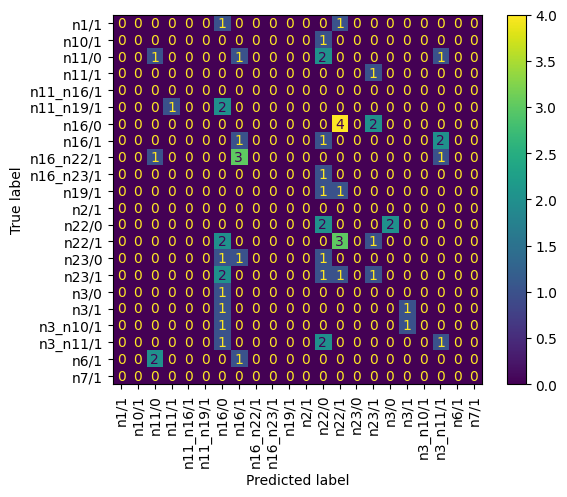

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90)
